In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
K = 99 # strike price
S0 = 100 # current price of the stock
N = 50 # time steps
sigma = 0.2 # volatility
r = .06 # risk free rate 
T = 1 # year

option price: 11.5464348508


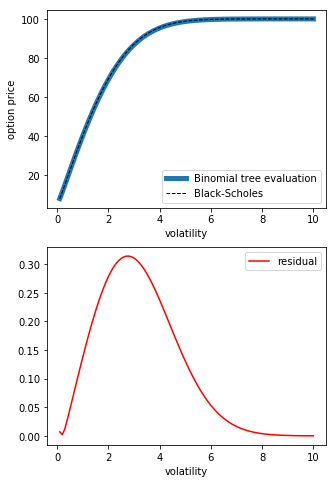

In [7]:
def binom(K, S0, N, sigma, r, T):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    option_tree = {}
    option_tree[N] = []
    for j in range(N, -1, -1):
        price = S0*(u**j)*(d**(N-j))
        option_tree[N].append( max(price-K, 0) )
    
    for i in range(N-1, -1, -1):
        option_tree[i] = []
        for j in range(i+1):
            opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
            option_tree[i].append( max(opt_price, 0) )
    
    return option_tree[0][0]

def get_bs(St, K, sigma, r, T, t):
    d1 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r + (sigma**2/2))*(T-t))
    d2 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r - (sigma**2/2))*(T-t))
    return norm.cdf(d1)*St - norm.cdf(d2)*K*np.exp(-r*(T-t))

option_price = binom(K, S0, N, sigma, r, T)
print('option price:', option_price)

sigma_range = np.arange(0.1, 10.1, 0.1)
tree_data = []
bs_data = []
for s in sigma_range:
    tree_data.append( binom(K, S0, N, s, r, T) )
    bs_data.append( get_bs(S0, K, s, r, T, 0) )
    
fig, ax = plt.subplots(2, 1, figsize=(5, 8))
    
ax[0].plot(sigma_range, tree_data, label='Binomial tree evaluation', linewidth=5)
ax[0].plot(sigma_range, bs_data, '--', c='black', label='Black-Scholes', linewidth=1)
ax[0].set_xlabel('volatility')
ax[0].set_ylabel('option price')

ax[1].plot(sigma_range, [abs(tree_data[i]-bs_data[i]) for i in range(len(tree_data))], c='red', label='residual')
ax[1].set_xlabel('volatility')

ax[0].legend()
ax[1].legend()

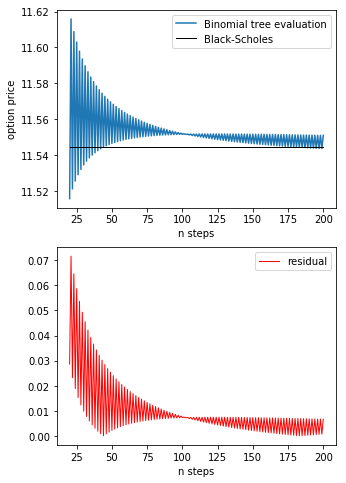

In [8]:
from scipy.stats import norm

n_range = np.arange(20, 201, 1)
data = []

for n in n_range:
    data.append( binom(K, S0, n, sigma, r, T) )
    
bs = get_bs(S0, K, sigma, r, T, 0)

fig, ax = plt.subplots(2, 1, figsize=(5, 8))
ax[0].plot(n_range, data, label='Binomial tree evaluation')
ax[0].plot(n_range, [bs for x in range(len(data))], c='black', label='Black-Scholes', linewidth=1)
ax[0].set_xlabel('n steps')
ax[0].set_ylabel('option price')
ax[0].legend()

ax[1].plot(n_range, [abs(bs-data[i]) for i in range(len(n_range))], linewidth=1, c='red', label='residual')
ax[1].set_xlabel('n steps')
ax[1].legend()
# ax[1].set_title('residual')

#### Hedge parameter

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


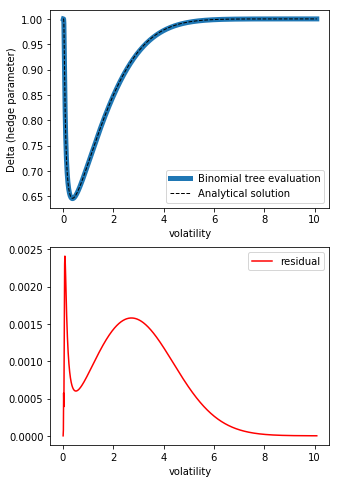

In [9]:
def hedge(St, K, sigma, r, T, t):
    d1 = (1 / sigma * np.sqrt(T-t))*( np.log(St/K) + (r + (sigma**2/2))*(T-t))
    return norm.cdf(d1)

def tree_hedge(K, S0, N, sigma, r, T):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    option_tree = {}
    option_tree[N] = []
    for j in range(N, -1, -1):
        price = S0*(u**j)*(d**(N-j))
        option_tree[N].append( max(price-K, 0) )
    
    for i in range(N-1, -1, -1):
        option_tree[i] = []
        for j in range(i+1):
            opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
            option_tree[i].append( max(opt_price, 0) )
    
    return (option_tree[1][0] - option_tree[1][1]) / (S0*(u-d))

s_range = np.arange(0, 10.1, 0.01)
data_1 = []
data_2 = []
for s in s_range:
    data_1.append( hedge(S0, K, s, r, T, 0) )
    data_2.append( tree_hedge(K, S0, N, s, r, T) ) 

fig, ax = plt.subplots(2, 1, figsize=(5, 8))
    
ax[0].plot(s_range, data_2, label='Binomial tree evaluation', linewidth=5)
ax[0].plot(s_range, data_1, '--', label='Analytical solution', c='black', linewidth=1)
ax[0].set_xlabel('volatility')
ax[0].set_ylabel('Delta (hedge parameter)')
ax[0].legend()

ax[1].plot(s_range, [abs(data_2[i] - data_1[i]) for i in range(len(data_1))], c='red', label='residual' )
ax[1].set_xlabel('volatility')
ax[1].legend()

plt.legend()

#### American call option

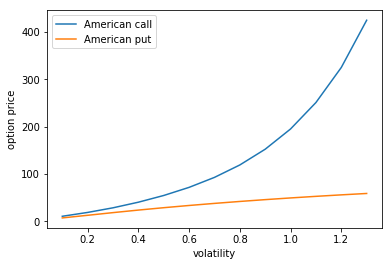

In [10]:
def american_option(K, S0, N, sigma, r, T, cp='call'):
    dt = T/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    
    option_tree = {}
    option_tree[N] = []
    for j in range(N, -1, -1):
        price = S0*(u**j)*(d**(N-j))
        if cp == 'call':
            option_tree[N].append( max(price-K, 0) )
        elif cp == 'put':
            option_tree[N].append( max(K-price, 0) )
    
    for i in range(N-1, -1, -1):
        option_tree[i] = []
        for j in range(i+1):
            if cp == 'call':
                opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
                early_exercise = S0*(u**j)*(d**(i-j)) - K
                option_tree[i].append( max(opt_price, early_exercise) )
            elif cp == 'put':
                opt_price = np.exp(-r*dt)*(p*option_tree[i+1][j] + (1-p)*option_tree[i+1][j+1])
                early_exercise = K - S0*(u**j)*(d**(i-j))
                option_tree[i].append( max(opt_price, early_exercise) )
    return option_tree[0][0]

sigma_range = np.arange(0.1, 1.4, 0.1)
call_data = []
put_data = []
for s in sigma_range:
    call_data.append( american_option(K, S0, N, s, r, T, cp='call') )
    put_data.append( american_option(K, S0, N, s, r, T, cp='put') )
    
plt.plot(sigma_range, call_data, label='American call')
plt.plot(sigma_range, put_data, label='American put')
plt.xlabel('volatility')
plt.ylabel('option price')
plt.legend()

## Hedging Simulations
### same sigma

cash: 80.9072752532 
loan: 139.3544803 
delta: 0.532838895773
delta*shares: 59.3169948817 
option price: 6.64774596372
payoff for K < ST
  cash - loan + K*delta + rand_option: 5.84812586207


Text(0.5, 1.0, 'Stock price (t)')

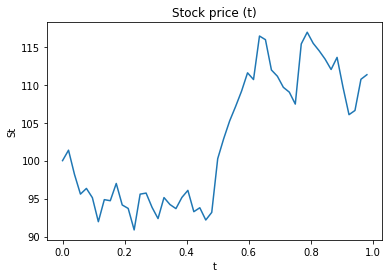

In [141]:
def get_hedge_simulation(St, K, sigma, r, T, N):
    h_list = []
    p_list = []
    s_list = []
    dt = T/N
    t_range = np.arange(0, T, dt)
    for t in t_range:
        h_list.append( hedge(St, K, sigma, r, T, t) )
        bs = get_bs(St, K, sigma, r, T, t)
        if bs > 0:
            p_list.append(bs)
        else:
            p_list.append(0)
        s_list.append(St)
        St += r*St*dt + sigma*St*(np.random.normal(0, 1)*np.sqrt(dt))
        
    return h_list, p_list, t_range, s_list

N = 52
S0 = 100

h_list, p_list, t_range, s_list = get_hedge_simulation(S0, K, sigma, r, T, N)

portfolio = []
loan = {}
cash = {}
shares = 0
loan[0] = 0

for i, t in enumerate(t_range):
    delta = hedge(s_list[i], K, sigma, r, T, t)
    if shares < delta:
        loan[t] = (delta - shares) * s_list[i]
        cash[t] = 0
        shares = delta
    elif shares > delta:
        loan[t] = 0
        cash[t] = (shares - delta) * s_list[i]
        shares = delta

total_cash = 0
total_loan = 0
for t in cash.keys():
    total_cash += cash[t]*np.exp(r*(T-t))
    total_loan += loan[t]*np.exp(r*(T-t))

print('cash:', total_cash, '\nloan:', total_loan, '\ndelta:', h_list[-1])
print('delta*shares:', h_list[-1]*s_list[-1], '\noption price:', p_list[-1])
if s_list[-1] > K:
    print('payoff for K < ST')
    print('  cash - loan + K*delta + rand_option:', total_cash-total_loan+K*h_list[-1]+p_list[0])
else:
    print('payoff for K > ST')
    print('  cash - loan + delta*ST + rand_option:', total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[0])
                                                                                                        
    
plt.plot(t_range, s_list)
plt.xlabel('t')
plt.ylabel('St')
plt.title('Stock price (t)')

(array([  1.83083978e-03,   1.23581685e-02,   2.01392376e-02,
          2.34347492e-02,   2.59063829e-02,   2.54486730e-02,
          3.67998796e-02,   3.36874520e-02,   3.73491316e-02,
          3.33212841e-02,   3.32297421e-02,   2.95680625e-02,
          2.70964288e-02,   2.05054056e-02,   1.83999398e-02,
          1.68437260e-02,   1.12596647e-02,   9.42882488e-03,
          8.87957295e-03,   6.40793924e-03,   4.48555747e-03,
          3.47859559e-03,   3.66167957e-03,   2.74625967e-03,
          1.64775580e-03,   2.10546575e-03,   1.37312984e-03,
          1.55621382e-03,   4.57709946e-04,   5.49251935e-04,
          6.40793924e-04,   5.49251935e-04,   4.57709946e-04,
          3.66167957e-04,   3.66167957e-04,   3.66167957e-04,
          9.15419892e-05,   0.00000000e+00,   9.15419892e-05,
          2.74625967e-04,   2.74625967e-04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   9.15419892e-05,
          0.00000000e+00,   0.00000000e+00,   9.15419892e-05,
        

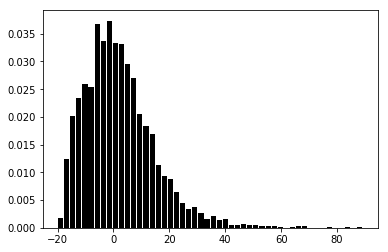

In [160]:
def get_hedge_simulation(St, K, sigma, r, T, N):
    h_list = []
    p_list = []
    s_list = []
    dt = T/N
    t_range = np.arange(0, T, dt)
    for t in t_range:
        h_list.append( hedge(St, K, sigma, r, T, t) )
        bs = get_bs(St, K, sigma, r, T, t)
        if bs > 0:
            p_list.append(bs)
        else:
            p_list.append(0)
        s_list.append(St)
        St += r*St*dt + sigma*St*(np.random.normal(0, 1)*np.sqrt(dt))
        
    return h_list, p_list, t_range, s_list

sims = 5000
N = 52
S0 = 100

payoffs_52 = []

for sim in range(sims):
    h_list, p_list, t_range, s_list = get_hedge_simulation(S0, K, sigma, r, T, N)
    
    loan = {}
    cash = {}
    shares = 0
    loan[0] = 0
    
    for i, t in enumerate(t_range):
        delta = hedge(s_list[i], K, sigma, r, T, t)
        if shares < delta:
            loan[t] = (delta - shares) * s_list[i]
            cash[t] = 0
            shares = delta
        elif shares > delta:
            loan[t] = 0
            cash[t] = (shares - delta) * s_list[i]
            shares = delta
    
    total_cash = 0
    total_loan = 0
    for t in cash.keys():
        total_cash += cash[t]*np.exp(r*(T-t))
        total_loan += loan[t]*np.exp(r*(T-t)) 
        
    if s_list[-1] > K:
        cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
        payoffs_52.append(cash)
    else:
        cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
        payoffs_52.append(cash)
    
plt.hist(payoffs_52, bins=50, density=True, align='mid', rwidth=0.85, color='black')

(array([  2.28504375e-03,   1.18822275e-02,   2.26981012e-02,
          2.77251975e-02,   2.72681887e-02,   3.80840625e-02,
          3.19144443e-02,   3.16097718e-02,   3.13812675e-02,
          2.84868787e-02,   2.78013656e-02,   2.09462344e-02,
          1.53097931e-02,   1.30247494e-02,   9.74951999e-03,
          8.91167062e-03,   6.39812249e-03,   4.64625562e-03,
          4.18924687e-03,   2.28504375e-03,   2.66588437e-03,
          2.05653937e-03,   1.37102625e-03,   1.67569875e-03,
          8.37849374e-04,   1.37102625e-03,   6.85513124e-04,
          4.57008750e-04,   5.33176874e-04,   3.80840625e-04,
          3.80840625e-04,   5.33176874e-04,   2.28504375e-04,
          7.61681249e-05,   2.28504375e-04,   0.00000000e+00,
          7.61681249e-05,   1.52336250e-04,   0.00000000e+00,
          7.61681249e-05,   1.52336250e-04,   7.61681249e-05,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.52336250e-04,   0.00000000e+00,
        

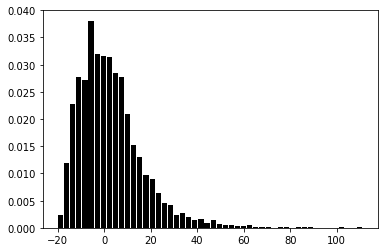

In [161]:
sims = 5000
N = 252
S0 = 100

payoffs_252 = []

for sim in range(sims):
    h_list, p_list, t_range, s_list = get_hedge_simulation(S0, K, sigma, r, T, N)
    
    loan = {}
    cash = {}
    shares = 0
    loan[0] = 0
    
    for i, t in enumerate(t_range):
        delta = hedge(s_list[i], K, sigma, r, T, t)
        if shares < delta:
            loan[t] = (delta - shares) * s_list[i]
            cash[t] = 0
            shares = delta
        elif shares > delta:
            loan[t] = 0
            cash[t] = (shares - delta) * s_list[i]
            shares = delta
    
    total_cash = 0
    total_loan = 0
    for t in cash.keys():
        total_cash += cash[t]*np.exp(r*(T-t))
        total_loan += loan[t]*np.exp(r*(T-t)) 
        
    if s_list[-1] > K:
        cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
        payoffs_252.append(cash)
    else:
        cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
        payoffs_252.append(cash)
    
plt.hist(payoffs_252, bins=50, density=True, align='mid', rwidth=0.85, color='black')

(array([ 0.00013318,  0.00026636,  0.00053271,  0.0011986 ,  0.00159814,
         0.00479442,  0.00945566,  0.01238558,  0.01504914,  0.01891131,
         0.0183786 ,  0.02130852,  0.0233062 ,  0.02250713,  0.02370573,
         0.02823379,  0.03222914,  0.03795581,  0.03942077,  0.04128526,
         0.04647921,  0.05899797,  0.07164991,  0.02663565,  0.01704682,
         0.01904449,  0.01265194,  0.01278511,  0.00878977,  0.00652574,
         0.00599302,  0.0061262 ,  0.00319628,  0.00253039,  0.00213085,
         0.00332946,  0.00292992,  0.0011986 ,  0.00053271,  0.00079907,
         0.00053271,  0.00039953,  0.0011986 ,  0.00026636,  0.00039953,
         0.00026636,  0.00039953,  0.00013318,  0.        ,  0.00026636]),
 array([-27.14172947, -25.63998293, -24.13823639, -22.63648985,
        -21.13474331, -19.63299678, -18.13125024, -16.6295037 ,
        -15.12775716, -13.62601062, -12.12426408, -10.62251755,
         -9.12077101,  -7.61902447,  -6.11727793,  -4.61553139,
         -3.

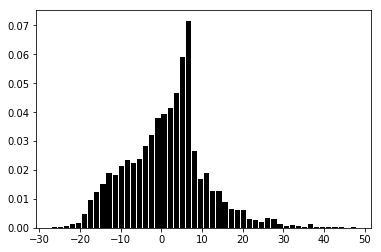

In [186]:
sims = 5000
N = 4
S0 = 100

payoffs_4 = []

for sim in range(sims):
    h_list, p_list, t_range, s_list = get_hedge_simulation(S0, K, sigma, r, T, N)
    
    loan = {}
    cash = {}
    shares = 0
    loan[0] = 0
    
    for i, t in enumerate(t_range):
        delta = hedge(s_list[i], K, sigma, r, T, t)
        if shares < delta:
            loan[t] = (delta - shares) * s_list[i]
            cash[t] = 0
            shares = delta
        elif shares > delta:
            loan[t] = 0
            cash[t] = (shares - delta) * s_list[i]
            shares = delta
    
    total_cash = 0
    total_loan = 0
    for t in cash.keys():
        total_cash += cash[t]*np.exp(r*(T-t))
        total_loan += loan[t]*np.exp(r*(T-t)) 
        
    if s_list[-1] > K:
        cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
        payoffs_4.append(cash)
    else:
        cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
        payoffs_4.append(cash)
    
plt.hist(payoffs_4, bins=50, density=True, align='mid', rwidth=0.85, color='black')

mean of weekly hedge: 2.15307041515 with std: 12.6481292265
mean of daily hedge: 2.86893772843 with std: 13.9275507642
mean of quarterly hedge: 1.42549334235 with std: 9.79938941537


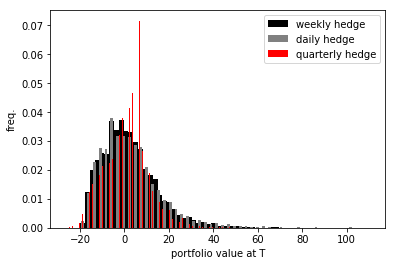

In [187]:
plt.hist(payoffs_52, bins=50, density=True, align='mid', rwidth=1, color='black', label='weekly hedge')
plt.hist(payoffs_252, bins=50, density=True, align='mid', rwidth=0.5, color='grey', label='daily hedge')
plt.hist(payoffs_4, bins=50, density=True, align='mid', rwidth=0.2, color='red', label='quarterly hedge')
plt.xlabel('portfolio value at T')
plt.ylabel('freq.')

print('mean of weekly hedge:', np.mean(payoffs_52), 'with std:', np.std(payoffs_52))
print('mean of daily hedge:', np.mean(payoffs_252), 'with std:', np.std(payoffs_252))
print('mean of quarterly hedge:', np.mean(payoffs_4), 'with std:', np.std(payoffs_4))

plt.legend()

### different sigma

(array([  2.82454295e-03,   2.07824169e-02,   3.30652917e-02,
          1.95644947e-02,   1.24383543e-02,   9.12145979e-03,
          5.70091237e-03,   4.69029608e-03,   3.99063866e-03,
          3.42054742e-03,   2.38401790e-03,   2.07305904e-03,
          1.55479428e-03,   1.39931485e-03,   1.01061628e-03,
          8.55136855e-04,   5.44177999e-04,   5.70091237e-04,
          8.03310379e-04,   3.88698570e-04,   5.18264761e-04,
          4.92351523e-04,   1.81392666e-04,   1.55479428e-04,
          2.07305904e-04,   1.03652952e-04,   1.29566190e-04,
          7.77397141e-05,   5.18264761e-05,   7.77397141e-05,
          7.77397141e-05,   2.59132380e-05,   1.03652952e-04,
          0.00000000e+00,   0.00000000e+00,   5.18264761e-05,
          2.59132380e-05,   2.59132380e-05,   0.00000000e+00,
          0.00000000e+00,   2.59132380e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.59132380e-05,   0.00000000e+00,
        

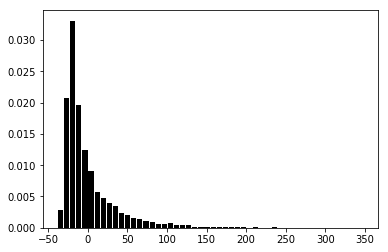

In [168]:
def get_hedge_simulation_b(St, K, sigma_s, sigma_p, r, T, N):
    h_list = []
    p_list = []
    s_list = []
    dt = T/N
    t_range = np.arange(0, T, dt)
    for t in t_range:
        h_list.append( hedge(St, K, sigma_p, r, T, t) )
        bs = get_bs(St, K, sigma_p, r, T, t)
        if bs > 0:
            p_list.append(bs)
        else:
            p_list.append(0)
        s_list.append(St)
        St += r*St*dt + sigma_s*St*(np.random.normal(0, 1)*np.sqrt(dt))
    
    return h_list, p_list, t_range, s_list

sims = 5000
N = 52
S0 = 100
sigma_s = 0.5
sigma_p = 0.2

payoffs_52b = []

for sim in range(sims):
    h_list, p_list, t_range, s_list = get_hedge_simulation_b(S0, K, sigma_s, sigma_p, r, T, N)
    
    loan = {}
    cash = {}
    shares = 0
    loan[0] = 0
    
    for i, t in enumerate(t_range):
        delta = hedge(s_list[i], K, sigma, r, T, t)
        if shares < delta:
            loan[t] = (delta - shares) * s_list[i]
            cash[t] = 0
            shares = delta
        elif shares > delta:
            loan[t] = 0
            cash[t] = (shares - delta) * s_list[i]
            shares = delta
    
    total_cash = 0
    total_loan = 0
    for t in cash.keys():
        total_cash += cash[t]*np.exp(r*(T-t))
        total_loan += loan[t]*np.exp(r*(T-t)) 
        
    if s_list[-1] > K:
        cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
        payoffs_52b.append(cash)
    else:
        cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
        payoffs_52b.append(cash)
    
plt.hist(payoffs_52b, bins=50, density=True, align='mid', rwidth=0.85, color='black')

(array([ 0.00181888,  0.00109133,  0.00109133,  0.00291021,  0.00545664,
         0.00618419,  0.00945817,  0.00909439,  0.01236837,  0.01855256,
         0.02146277,  0.03273982,  0.04983728,  0.04838217,  0.05165615,
         0.05311126,  0.05893167,  0.07457402,  0.08475975,  0.07966689,
         0.09276281,  0.09967455,  0.09458169,  0.09785567,  0.09203526,
         0.10622251,  0.10294853,  0.09931077,  0.0974919 ,  0.10585874,
         0.08075821,  0.0494735 ,  0.03128471,  0.02037144,  0.00836684,
         0.00691174,  0.00218265,  0.0014551 ,  0.0014551 ,  0.00109133,
         0.00109133,  0.00036378,  0.00109133,  0.        ,  0.00072755,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00036378]),
 array([ -8.8855236 ,  -8.33573432,  -7.78594503,  -7.23615574,
         -6.68636645,  -6.13657717,  -5.58678788,  -5.03699859,
         -4.4872093 ,  -3.93742002,  -3.38763073,  -2.83784144,
         -2.28805215,  -1.73826287,  -1.18847358,  -0.63868429,
         -0.

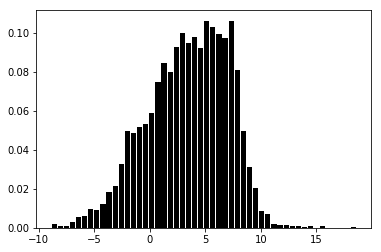

In [193]:
def get_hedge_simulation_b(St, K, sigma_s, sigma_p, r, T, N):
    h_list = []
    p_list = []
    s_list = []
    dt = T/N
    t_range = np.arange(0, T, dt)
    for t in t_range:
        h_list.append( hedge(St, K, sigma_p, r, T, t) )
        bs = get_bs(St, K, sigma_p, r, T, t)
        if bs > 0:
            p_list.append(bs)
        else:
            p_list.append(0)
        s_list.append(St)
        St += r*St*dt + sigma_s*St*(np.random.normal(0, 1)*np.sqrt(dt))
    
    return h_list, p_list, t_range, s_list

sims = 5000
N = 52
S0 = 100
sigma_s = 0.05
sigma_p = 0.2

payoffs_52c = []

for sim in range(sims):
    h_list, p_list, t_range, s_list = get_hedge_simulation_b(S0, K, sigma_s, sigma_p, r, T, N)
    
    loan = {}
    cash = {}
    shares = 0
    loan[0] = 0
    
    for i, t in enumerate(t_range):
        delta = hedge(s_list[i], K, sigma, r, T, t)
        if shares < delta:
            loan[t] = (delta - shares) * s_list[i]
            cash[t] = 0
            shares = delta
        elif shares > delta:
            loan[t] = 0
            cash[t] = (shares - delta) * s_list[i]
            shares = delta
    
    total_cash = 0
    total_loan = 0
    for t in cash.keys():
        total_cash += cash[t]*np.exp(r*(T-t))
        total_loan += loan[t]*np.exp(r*(T-t)) 
        
    if s_list[-1] > K:
        cash = total_cash-total_loan+K*h_list[-1]+p_list[np.random.randint(0, len(p_list))]
        payoffs_52c.append(cash)
    else:
        cash = total_cash-total_loan+h_list[-1]*s_list[-1]+p_list[np.random.randint(0, len(p_list))] 
        payoffs_52c.append(cash)
    
plt.hist(payoffs_52c, bins=50, density=True, align='mid', rwidth=0.85, color='black')

stock sigma = 20%: 2.15307041515 with std: 12.6481292265
stock sigma = 50%: -0.0238141117412 with std: 35.1167452211
stock sigma = 5%: 3.43783418278 with std: 3.62796031573


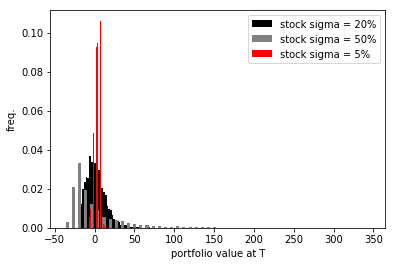

In [195]:
plt.hist(payoffs_52, bins=50, density=True, align='mid', rwidth=1, color='black', label='stock sigma = 20%')
plt.hist(payoffs_52b, bins=50, density=True, align='mid', rwidth=0.5, color='grey', label='stock sigma = 50%')
plt.hist(payoffs_52c, bins=50, density=True, align='mid', rwidth=0.4, color='red', label='stock sigma = 5%')
plt.xlabel('portfolio value at T')
plt.ylabel('freq.')

print('stock sigma = 20%:', np.mean(payoffs_52), 'with std:', np.std(payoffs_52))
print('stock sigma = 50%:', np.mean(payoffs_52b), 'with std:', np.std(payoffs_52b))
print('stock sigma = 5%:', np.mean(payoffs_52c), 'with std:', np.std(payoffs_52c))

plt.legend()